# Calibration - Reliability Diagrams of Dirichlet.

Generate reliability diagrams for the Dirichlet paper.

1. Models need to be trained and tuned for calibrators
    1. Dir-odir (dir_l2_mu_off)
    2. For that read ReadMe.txt in scripts folder.
2. Get only the best tunings as separate folder (TODO find the script for that)
2. Run this notebook

In [1]:
import sys
from os import path
sys.path.append( path.dirname( path.dirname( path.abspath("calibration") ) ) )

In [2]:
import numpy as np
import pandas as pd
from os.path import join
from calibration.cal_methods import evaluate, cal_results, TemperatureScaling, Dirichlet_NN
from dirichlet import FullDirichletCalibrator
import pickle
from tune_dirichlet_nn_slim import kf_model
from utility.unpickle_probs import unpickle_probs
from utility.evaluation import softmax, get_bin_info, ECE
from sklearn.metrics import log_loss

Using TensorFlow backend.


In [3]:
import sys
from os import path
import os

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns

In [5]:
from IPython.display import display

In [6]:
import sys
from os import path
import os
import glob

In [7]:
from sklearn.preprocessing import label_binarize


## Get the best Lambda for each model

Path to logits and tuning

In [8]:
PATH_models_l2_mu_off = join("..", "..", "model_weights", "models_best_dir_l2_mu_off")
## NB! Folder contains already weights with optimal parameters.

PATH = join('..', '..', 'logits')
files_10 = ('probs_resnet_wide32_c10_logits.p', 'probs_densenet40_c10_logits.p',
            'probs_lenet5_c10_logits.p', 'probs_resnet110_SD_c10_logits.p',
           'probs_resnet110_c10_logits.p', 'probs_resnet152_SD_SVHN_logits.p')

files_100 = ('probs_resnet_wide32_c100_logits.p', 'probs_densenet40_c100_logits.p',
             'probs_lenet5_c100_logits.p', 'probs_resnet110_SD_c100_logits.p',
             'probs_resnet110_c100_logits.p')

## Load in models

In [9]:
def get_weights_dir(path, ext = ".p"):

    file_path = join(path, "*" + ext)
    files = glob.glob(file_path)

    dict_weights = {}
    dict_params = {}

    for fname in files:

        with open(fname, "rb") as f:
            models, (name, l2, mu) = pickle.load(f)
            weights = []

            for w in models:
                w = np.hstack([w[0].T, w[1].reshape(-1,1)])
                weights.append(w)

        dict_weights[name] = np.array(weights)
        dict_params[name] = [l2, mu]

    return (dict_weights, dict_params)

In [10]:
weights_params_l2_mu_off = get_weights_dir(PATH_models_l2_mu_off)


## Reliability Diagrams

### Compute Accuracy and Confidence of a Bin

In [11]:
def get_bin_info2(probs, true, bin_size = 0.1, ece_full = False, normalize = False, k = -1):
    
    probs = np.array(probs)
    true = np.array(true)
    
    if len(true.shape) == 2 and true.shape[1] > 1:
        true = true.argmax(axis=1).reshape(-1, 1)
    
    if k == -1:
    
        if ece_full:

            pred, conf, true = get_preds_all(probs, true, normalize=normalize, flatten=ece_full)
        else:
            pred = np.argmax(probs, axis=1)  # Take maximum confidence as prediction

            if normalize:
                conf = np.max(probs, axis=1)/np.sum(probs, axis=1)
                # Check if everything below or equal to 1?
            else:
                conf = np.max(probs, axis=1)  # Take only maximum confidence
        
    else:
        pred, conf, true = get_preds_k(probs, true, k)

    
    # get predictions, confidences and true labels for all classes  
    
    upper_bounds = np.arange(bin_size, 1+bin_size, bin_size)  # Get bounds of bins
    
    n = len(conf)
    ece = 0  # Starting error
    
    accuracies = []
    confidences = []
    bin_lengths = []
    
    for conf_thresh in upper_bounds:  # Go through bounds and find accuracies and confidences
        acc, avg_conf, len_bin = compute_acc_bin(conf_thresh-bin_size, conf_thresh, conf, pred, true, ece_full)  
        
        accuracies.append(acc)
        confidences.append(avg_conf)
        bin_lengths.append(len_bin)
        
    return np.array(accuracies), np.array(confidences), np.array(bin_lengths)

In [12]:
def compute_acc_bin(conf_thresh_lower, conf_thresh_upper, conf, pred, true, ece_full = False):
    """
    # Computes accuracy and average confidence for bin
    
    Args:
        conf_thresh_lower (float): Lower Threshold of confidence interval
        conf_thresh_upper (float): Upper Threshold of confidence interval
        conf (numpy.ndarray): list of confidences
        pred (numpy.ndarray): list of predictions
        true (numpy.ndarray): list of true labels
        pred_thresh (float) : float in range (0,1), indicating the prediction threshold
    
    Returns:
        (accuracy, avg_conf, len_bin): accuracy of bin, confidence of bin and number of elements in bin.
    """
    filtered_tuples = [x for x in zip(pred, true, conf) if (x[2] > conf_thresh_lower or conf_thresh_lower == 0) and x[2] <= conf_thresh_upper]  
    
    if len(filtered_tuples) < 1:
        return 0,0,0
    else:
        if ece_full:
            len_bin = len(filtered_tuples)  # How many elements falls into given bin
            avg_conf = sum([x[2] for x in filtered_tuples])/len_bin  # Avg confidence of BIN
            accuracy = np.mean([x[1] for x in filtered_tuples])  # Mean difference from actual class
        
        else:
            correct = len([x for x in filtered_tuples if x[0] == x[1]])  # How many correct labels
            len_bin = len(filtered_tuples)  # How many elements falls into given bin
            avg_conf = sum([x[2] for x in filtered_tuples]) / len_bin  # Avg confidence of BIN
            accuracy = float(correct)/len_bin  # accuracy of BIN
        
    return accuracy, avg_conf, len_bin

#### Old function, but it together with new

In [13]:
from sklearn.preprocessing import OneHotEncoder

def get_preds_all(y_probs, y_true, axis = 1, normalize = False, flatten = True):
    
    y_preds = np.argmax(y_probs, axis=axis)  # Take maximum confidence as prediction
    y_preds = y_preds.reshape(-1, 1)
    
    if normalize:
        y_probs /= np.sum(y_probs, axis=axis)
        
    enc = OneHotEncoder(handle_unknown='ignore', sparse=False)   
    enc.fit(y_preds)

    y_preds = enc.transform(y_preds)
    y_true = enc.transform(y_true)
    
    if flatten:        
        y_preds = y_preds.flatten()
        y_true = y_true.flatten()
        y_probs = y_probs.flatten()
        
    return y_preds, y_probs, y_true

In [14]:
from sklearn.preprocessing import OneHotEncoder

def get_preds_k(y_probs, y_true, k, axis = 1):
    
    y_probs = y_probs[:, k]  # Take maximum confidence as prediction
    y_preds = np.repeat(k, len(y_probs))   
        
    return y_preds, y_probs, y_true

In [15]:
def get_uncalibrated_res(path, file, M = 15, method = np.max, k = -1):
    
    bin_size = 1/M

    FILE_PATH = join(path, file)
    (y_logits_val, y_val), (y_logits_test, y_test) = unpickle_probs(FILE_PATH)
    
    y_probs_val = softmax(y_logits_val)
    y_probs_test = softmax(y_logits_test)

    res_test = get_bin_info2(y_probs_test, y_test, bin_size = bin_size, k = k)
    res_val = get_bin_info2(y_probs_val, y_val, bin_size = bin_size, k = k)
    
    return (res_test, res_val)



In [16]:
def cal_res(method, path, file, M = 15, m_kwargs = {}, k = -1):
    
    bin_size = 1/M

    FILE_PATH = join(path, file)
    (y_logits_val, y_val), (y_logits_test, y_test) = unpickle_probs(FILE_PATH)
    
    y_probs_val = softmax(y_logits_val)  # Softmax logits
    y_probs_test = softmax(y_logits_test)
    

    model = method(**m_kwargs)
    model.fit(y_logits_val, y_val)

    y_probs_val = model.predict(y_logits_val) 
    y_probs_test = model.predict(y_logits_test)

    accs_val, confs_val, len_bins_val = get_bin_info2(y_probs_val, y_val, bin_size = bin_size, k = k)
    accs_test, confs_test, len_bins_test = get_bin_info2(y_probs_test, y_test, bin_size = bin_size, k = k)
    
    return (accs_test, confs_test, len_bins_test), (accs_val, confs_val, len_bins_val)
    

In [17]:
def get_preds(x, w):
    return softmax(np.log(clip_for_log(x)) @ w[:, :-1].T + w[:, -1])

In [18]:
def clip_for_log(X):
    eps = np.finfo(float).eps
    return np.clip(X, eps, 1-eps)

In [19]:
def get_dir_results(file, weights_model, M = 15, k = -1):
    
    bin_size = 1/M
    
    FILE_PATH = join(PATH, file)
    (logits_val, y_val), (logits_test, y_test) = unpickle_probs(FILE_PATH)

    probs_val = softmax(logits_val)  # Softmax logits
    probs_test = softmax(logits_test)
    
    results_val = []
    results_test = []

    for w in weights_model:
        get_preds(probs_test, w)
        results_val.append(get_preds(probs_val, w))
        results_test.append(get_preds(probs_test, w))


    results_val_mean = np.mean(results_val, axis=0)
    results_test_mean = np.mean(results_test, axis=0)
    
    accs_val, confs_val, len_bins_val = get_bin_info2(results_val_mean, y_val, bin_size = bin_size, k = k)
    accs_test, confs_test, len_bins_test = get_bin_info2(results_test_mean, y_test, bin_size = bin_size, k = k)

    return (accs_test, confs_test, len_bins_test), (accs_val, confs_val, len_bins_val)

In [20]:
def plot_bin_importance(values, ax, M = 15, name = "Importance of Bins", xname = "Confidence", yname=""):

    """Plot that shows how much each confidence interval adds to final ECE"""

    bin_size = 1/M
    positions = np.arange(0+bin_size/2, 1+bin_size/2, bin_size)
    ax.bar(positions, values, width = bin_size, edgecolor = "black", color = "blue", label="Outputs", zorder = 3)
    
    ax.set_aspect('equal')
    #ax.plot([0,1], [0,1], linestyle = "--")
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_title(name, fontsize=24)
    ax.set_xlabel(xname, fontsize=22, color = "black")
    ax.set_ylabel(yname, fontsize=22, color = "black")

In [21]:
def get_errors(bin_info):
    # Get error_standardized and ECE
    
    error = np.abs(np.array(bin_info[0]) - np.array(bin_info[1]))
    lens = bin_info[2]
    n = sum(lens)
    error_norm = error*lens/n
    error_standard = error_norm/sum(error_norm)
    ECE = sum(error_norm)
    
    return error_standard, ECE

### Generate lineplots

In [22]:
def get_accs_confs(k, weights_all = weights_params_l2_mu_off, file = files_10[0], M = 15, v = 0):
    
    bin_info_uncal = get_uncalibrated_res(PATH, file, M=M, k=k)

    accs_confs = [bin_info_uncal[v]]

    accs_confs.append(cal_res(TemperatureScaling, PATH, file, M=M, k=k)[v])

    name = "_".join(file.split("_")[1:-1])  # file_name
    print(name)
    accs_confs.append(get_dir_results(file, weights_all[0][name], M=M, k=k)[v])
    
    return np.array(accs_confs)

In [23]:
def gen_lineplots(files, weights_all, plot_names =  [], M = 15, val_set = False, version = "ECE", classes = 10, extra_plots = False):
    
    if val_set:  # Plot Reliability diagrams for validation set
        v = 1
    else:
        v = 0
        

    for i, file in enumerate(files):
        
        k_accs_confs = []
        
        if classes > 0:
        
            for k in range(classes):

                accs_confs = get_accs_confs(k, weights_all = weights_all, file = file, M = M, v = v)
                k_accs_confs.append(accs_confs)
        
        else:
            return get_accs_confs(-1, weights_all = weights_all, file = file, M = M, v = v)
        
        
    return np.array(k_accs_confs)

In [24]:
k_accs_confs = gen_lineplots([files_10[0]], weights_params_l2_mu_off, M = 15)

resnet_wide32_c10
resnet_wide32_c10
resnet_wide32_c10
resnet_wide32_c10
resnet_wide32_c10
resnet_wide32_c10
resnet_wide32_c10
resnet_wide32_c10
resnet_wide32_c10
resnet_wide32_c10


In [25]:
conf_ECE_accs_confs = gen_lineplots([files_10[0]], weights_params_l2_mu_off, M = 15, classes=-1)

resnet_wide32_c10


In [26]:
def plot_comp1(bin_info, k = 0):
    
    if k != -1:
        bin_info = bin_info[k]
        
    accs = bin_info[0, 0]
    accs_temp = bin_info[1, 0]
    accs_dir = bin_info[2, 0]


    x = np.linspace(0, 1, 15)
    plt.plot(x, x, linestyle=":", color = "gray")
    plt.step(x = x, y = accs, where="mid", linestyle="--", color = "red",
              linewidth=2.5, label="Uncal. (ECE=%0.4f)" % get_errors(bin_info[0])[1])
    plt.step(x = x, y = accs_temp, where="mid", linestyle="-.", color = "blue",
              linewidth=2.5, label="Temp. (ECE=%0.4f)" % get_errors(bin_info[1])[1])
    plt.step(x = x, y = accs_dir, where="mid", linestyle="-", color="green", 
              linewidth=2.5, label="Diri.    (ECE=%0.4f)" % get_errors(bin_info[2])[1])
    plt.legend(prop={'size': 12})
    
    #plt.axes.Axes.set_aspect('equal')
    
    if k == -1:
        plt.title("Confidence ECE")
    else:
        plt.title("Calibration of class %i" % k)
    
    #plt.savefig("Comp1_k=%i.pdf" % k, format='pdf', dpi=1000, bbox_inches='tight', pad_inches=0.2)
    #plt.show()

In [27]:
def get_errors(bin_info):
    # Get error_standardized and ECE
    
    error = np.abs(np.array(bin_info[0]) - np.array(bin_info[1]))
    lens = bin_info[2]
    n = sum(lens)
    error_norm = error*lens/n
    error_standard = error_norm/sum(error_norm)
    ECE = sum(error_norm)
    
    return error_standard, ECE

In [28]:
# reliability diagram plotting for subplot case.
def rel_diagram_sub2(accs, confs, ax, M = 10, name = "Reliability Diagram", xname = "", yname="", 
                     gname = "Gap (conf-ECE=%0.4f)", ece = -1, leg_name = "Observed accuracy"):

    acc_conf = np.column_stack([accs,confs])
    #acc_conf.sort(axis=1)  # No need to sort
    outputs = np.array(accs)  # Accuracy
    gap = confs - outputs  # Absolute difference between accuracy and confidence
    bottoms = accs

    bin_size = 1/M
    positions = np.arange(0+bin_size/2, 1+bin_size/2, bin_size)


    #Bars with outputs
    output_plt = ax.bar(positions, outputs, width = bin_size, edgecolor = "black", color = "blue", label=leg_name, 
                        alpha = 1, zorder = 2)

    # Plot gap first, so its below everything
    gap_plt = ax.bar(positions, gap, bottom = bottoms, width = bin_size*0.3, edgecolor = "red", color = "#ffc8c6", 
                 alpha = 1, label=gname % ece, linewidth=1, zorder=2)



    # Line plot with center line.
    ax.set_aspect('equal')
    ax.plot([0,1], [0,1], linestyle = "--")
    ax.legend(handles = [gap_plt, output_plt], prop={'size': 15})
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_title(name, fontsize=24)
    ax.set_xlabel(xname, fontsize=22, color = "black")
    ax.set_ylabel(yname, fontsize=22, color = "black")
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(15) 
        #tick.label.set_rotation('vertical')
    
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(15) 


### Figure 1 in the main article.

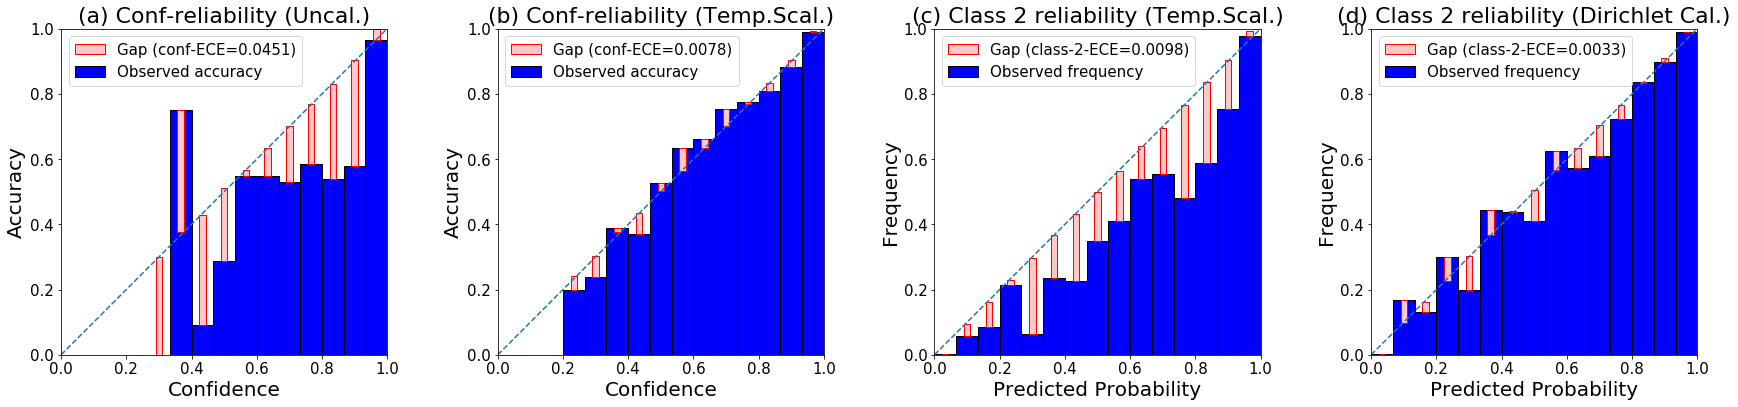

In [29]:
ece1 = get_errors(conf_ECE_accs_confs[0])[1]
ece2 = get_errors(conf_ECE_accs_confs[1])[1]
ece3 = get_errors(k_accs_confs[2][1])[1]
ece4 = get_errors(k_accs_confs[2][2])[1]


fig = plt.figure(figsize=(30,6))
#fig.set_edgecolor('red')
ax0 = fig.add_subplot(141)
rel_diagram_sub2(conf_ECE_accs_confs[0][0], conf_ECE_accs_confs[0][1], ax0 , M = 15, 
                            name = "(a) Confidence ECE (Uncal.)", xname="", ece = ece1)
ax1 = fig.add_subplot(142)
rel_diagram_sub2(conf_ECE_accs_confs[1][0], conf_ECE_accs_confs[1][1], ax1 , M = 15, 
                            name = "(b) Confidence ECE (Temp.)", xname="", ece = ece2)

ax2 = fig.add_subplot(143, sharex=ax1)

rel_diagram_sub2(k_accs_confs[2][1][0], k_accs_confs[2][1][1], ax2 , M = 15, 
                            name = "(c) Class 2 reliability (Temp.Scal.)", xname="", 
                 gname=r'Gap (class-2-ECE=%0.4f)', ece = ece3, leg_name = "Observed frequency")

ax3 = fig.add_subplot(144, sharex=ax1)

rel_diagram_sub2(k_accs_confs[2][2][0], k_accs_confs[2][2][1], ax3 , M = 15, 
                            name = "(d) Class 2 reliability (Dirichlet Cal.)", xname="", 
                 gname=r'Gap (class-2-ECE=%0.4f)', ece = ece4, leg_name = "Observed frequency")

names = ["(a) Conf-reliability (Uncal.)", "(b) Conf-reliability (Temp.Scal.)",
         "(c) Class 2 reliability (Temp.Scal.)", "(d) Class 2 reliability (Dirichlet Cal.)"]

axes_all = [ax0, ax1, ax2, ax3]

for i, ax in enumerate(axes_all):
    ax.set_aspect("equal")
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_title(names[i], fontsize=22)
    ax.set_ylabel("Accuracy", fontsize=20, color = "black")
    ax.set_xlabel("Confidence", fontsize=20, color = "black")
    
for ax in axes_all[2:]:
    ax.set_ylabel("Frequency", fontsize=20, color = "black")
    ax.set_xlabel("Predicted Probability", fontsize=20, color = "black")

plt.savefig("figure_RD_ECE.pdf", format='pdf', dpi=1000, bbox_inches='tight', pad_inches=0.2)
plt.show()

## Figure 12 in Supplemental Material

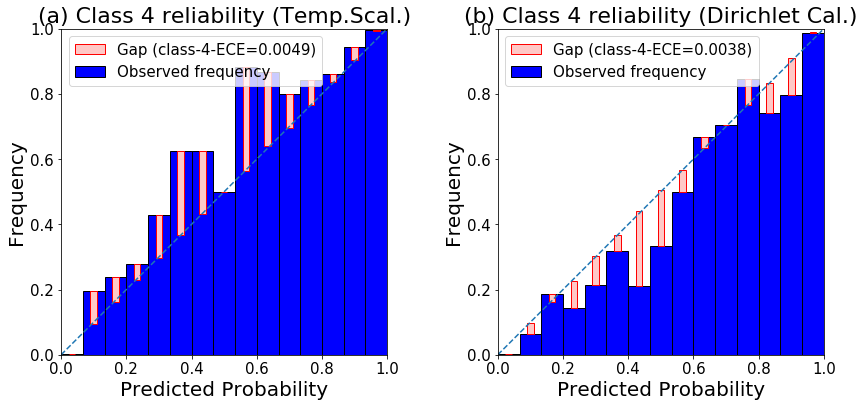

In [30]:
ece1 = get_errors(conf_ECE_accs_confs[0])[1]
ece2 = get_errors(conf_ECE_accs_confs[1])[1]
ece3 = get_errors(k_accs_confs[4][1])[1]
ece4 = get_errors(k_accs_confs[4][2])[1]


fig = plt.figure(figsize=(30,6))
#fig.set_edgecolor('red')
#ax0 = fig.add_subplot(141)
#rel_diagram_sub2(conf_ECE_accs_confs[0][0], conf_ECE_accs_confs[0][1], ax0 , M = 15, 
#                            name = "(a) Confidence ECE (Uncal.)", xname="", ece = ece1)
#ax1 = fig.add_subplot(142)
#rel_diagram_sub2(conf_ECE_accs_confs[1][0], conf_ECE_accs_confs[1][1], ax1 , M = 15, 
#                            name = "(b) Confidence ECE (Temp.)", xname="", ece = ece2)

ax2 = fig.add_subplot(143, sharex=ax1)

rel_diagram_sub2(k_accs_confs[4][1][0], k_accs_confs[2][1][1], ax2 , M = 15, 
                            name = "(c) Class 2 reliability (Temp.Scal.)", xname="", 
                 gname=r'Gap (class-4-ECE=%0.4f)', ece = ece3, leg_name = "Observed frequency")

ax3 = fig.add_subplot(144, sharex=ax1)

rel_diagram_sub2(k_accs_confs[4][2][0], k_accs_confs[2][2][1], ax3 , M = 15, 
                            name = "(d) Class 2 reliability (Dirichlet Cal.)", xname="", 
                 gname=r'Gap (class-4-ECE=%0.4f)', ece = ece4, leg_name = "Observed frequency")

names = ["(a) Conf-reliability (Uncal.)", "(b) Conf-reliability (Temp.Scal.)",
         "(a) Class 4 reliability (Temp.Scal.)", "(b) Class 4 reliability (Dirichlet Cal.)"]

axes_all = [ax0, ax1, ax2, ax3]

for i, ax in enumerate(axes_all):
    ax.set_aspect("equal")
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_title(names[i], fontsize=22)
    ax.set_ylabel("Accuracy", fontsize=20, color = "black")
    ax.set_xlabel("Confidence", fontsize=20, color = "black")
    
for ax in axes_all[2:]:
    ax.set_ylabel("Frequency", fontsize=20, color = "black")
    ax.set_xlabel("Predicted Probability", fontsize=20, color = "black")

plt.savefig("figure_RD_ECE_class4.pdf", format='pdf', dpi=1000, bbox_inches='tight', pad_inches=0.2)
plt.show()